In [1]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import graphviz
import re

# Phonology sets
h_tone = set("áéíóú")
l_tone = set("àèìòù")
f_tone = set("âêîôû")
r_tone = set("ǎěǐǒǔ")
untoned = set("aeiou")  # For long vowels (â indicates a short vowel with fall tone; âa a long F)
vowels = h_tone | l_tone | r_tone | f_tone | untoned
tones = h_tone | l_tone  # Combine high and low tones
special_tones = r_tone | f_tone  # Special tones (F, R)

max_syl_weight = 3 #default
tone_bearing_unit = 0 # 0: syllable 1:mora
"""
In this program, the tbu will determin how tones are mapped 
1. if syllables, 

"""
moraic_coda = 1  # 1 if coda carries mora, else 0
word_edge = 1 #1 if there are word boundaries; 0 no boundary



class Autorep:

    def __init__(self, word='', ocp_mel='', assoc=None, boundary=0):
        """
        Initialize an Autorep object.

        Parameters:
        - word (str): The word with tone markers.
        - tone (str): The tone markers directly extracted from the word (HFLR).
        - mel (str): The melody (F -> HL and R -> LH) before OCP.
        - ocp_mel (str): The OCP-applied tone representation of the word.
        - assoc (list): A list of tuples (j, k) indicating the association 
                        between tone (indexed by j), mora (indexed by i), 
                        and syllable (indexed by k).
        """
        self.word = word
        self.tone = ""
        self.mel = ""
        self.ocp_mel = ocp_mel
        self.assoc = self.sort_assoc(assoc if assoc is not None else [])
    
        self.boundary = boundary

        self.tone_labels = {"H": h_tone, "L": l_tone, "F": f_tone, "R": r_tone}
        
        
        if self.word:
            self._process_word()
        
        # if self.boundary == 1:
        #     self.ocp_mel_wb = self._wrap()[0]
        #     self.boundary = self._wrap()[1]
        
        self.syl_list = [i + 1 for i in range(self.get_max("s"))]
        self.moralist = [max((tup[1] for tup in self.assoc if tup[-1] == j), default=0) for j in self.syl_list
                         ]
        
        
       

    # def _wrap(self,num = 1):
    #     self.ocp_mel_wb = '<' + self.ocp_mel + '>'
        
    #     # Create a set to store word boundaries
    #     self.boundary = set()
        
    #     if self.ocp_mel:
    #     # Check beginning of the word
    #         if self.ocp_mel[0] == "H":
    #             self.boundary.add("<H")
    #         elif self.ocp_mel[0] == "L":
    #             self.boundary.add("<L")

    #         # Check end of the word
    #         if self.ocp_mel[-1] == "H":
    #             self.boundary.add("H>")
    #         elif self.ocp_mel[-1] == "L":
    #             self.boundary.add("L>")
        
    #     return self.ocp_mel_wb, self.boundary



         
    def _process_word(self):
        """Process the word to extract tones, assign associations, and apply OCP."""
        syllables = self.word.split(".")
        self.tone = "".join(
            next((k for k, v in self.tone_labels.items() if seg in v), "") 
            for seg in self.word
        )

        if len(syllables) == len(self.tone):
            for i, syl in enumerate(syllables):
                syl_weight = self.check_coda(syl) + self.vowel_count(syl)
                ### if wants do mora bering 
                # for j in range(syl_weight):
                #     self.assoc.append((self.tone[i], j + 1, i + 1))
                self.assoc.append((self.tone[i], syl_weight, i + 1))
                
        # else:
        #     print(f"something seems of {self.show()}")
       
        self._flatten_tones(syllables)  # convert F and R into HL and LH
        self.mel = "".join(tone for tone, _, _ in self.assoc)
        self.ocp_mel = re.sub(r"(.)\1+", r"\1", self.mel)
        self._update_tone_indices()
        
        

    def _flatten_tones(self, syllables):
        # print(self.assoc)
        tone_map = {"F": ("H", "L"), "R": ("L", "H")}
        for tone, (t1, t2) in tone_map.items():
            # print(tone, (t1, t2))
            if tone in self.tone:
                for i, (t, m, s) in enumerate(self.assoc):
                        # print(t, m, s)
                        if t == tone:
                            self.assoc[i] = (t1,m,s)
                            self.assoc.insert(i+1,(t2,m,s))
        
        
    def _update_tone_indices(self):
        """Update tone indices in association list to match OCP melody."""
        j, i = 0, 0
        while j < len(self.assoc) and i < len(self.ocp_mel):
            if self.assoc[j][0] == self.ocp_mel[i]:
                t, m, s = self.assoc[j]
                self.assoc[j] = (i + 1, m, s)  # Update tone index
                j += 1
            else:
                i += 1
    


    def get_max(self, target):
        """
        self.get_max('t') returns the biggest indexed tone
        self.get_max('s') returns the biggest indexed syllable
        self.get_max('m') returns the total moras
        """
        index_map = {'t': 0, 's': 2}

        if target in index_map:
            return max(
                (item[index_map[target]] for item in self.assoc if item[index_map[target]] is not None), 
                default=0
            )
        elif target == 'm':
            return sum(self.moralist)  # Return the sum of self.moralist if target is 'm'

        return 0  # Return 0 for invalid target
    
    @staticmethod
    def check_coda(syl):
        """Check if a syllable contains a coda."""
        for i in range(1, len(syl)):
            if syl[i] not in vowels and syl[i - 1] in vowels:
                return moraic_coda
        return 0

    @staticmethod
    def vowel_count(syl):
        """Count the number of vowels and adjust for special tones."""
        count = 0
        for i, char in enumerate(syl):
            if char in vowels or char in tones:
                count += 1
            elif (
                char in special_tones
                and i + 1 < len(syl)
                and syl[i + 1] not in vowels
            ):
                count += 2
        return count

    @staticmethod
    def mora_count(string):
        """Count the number of mora in a string."""
        mora_count = 0
        mora_list = []
        syllables = string.split(".")
        for syl in syllables:
            syl_weight = Autorep.check_coda(syl) + Autorep.vowel_count(syl)
            mora_list.append(syl_weight)
            mora_count += syl_weight
        return mora_count, mora_list                                
    
    @staticmethod
    def contour_count(s):
        """Count the number of contour tones in a string."""
        return sum(1 for char in s if char in special_tones)

    @staticmethod
    def index_reset(lst):   

        """Reset indices of the association list to start from 1."""
        if not lst:
            return []
        
        else:
            t_shift = min((t for (t, _, _) in lst if t is not None), default=0)
            # m_shift = (m for (_, m, _ )in lst if m is not None)
            s_shift = min((s for( _, _, s) in lst if s is not None), default=0)


            return [
                (
                    (t - t_shift + 1) if t else None,
                    m,
                    (s - s_shift + 1) if s else None,
                )
                for (t, m, s) in lst
            ]

    @staticmethod
    def sort_assoc(assoc):
        def custom_compare(x):
            return float('inf') if x is None else x

        sorted_assoc = sorted(
            assoc, 
            key=lambda x: custom_compare(x[0]) if x[0] is not None 
                 else custom_compare(x[2]) if x[2] is not None 
                 else custom_compare(x[1]))
        return sorted_assoc
        
        
    def check_empty(self):
        """Check if the object is empty."""
        return not (self.word or self.assoc or self.mel or self.ocp_mel)
    
    
    
    @staticmethod
    def is_modified_substring(list_a, list_b):
        # print(list_a,list_b)
        n, m = len(list_a), len(list_b)
        
        for i in range(m - n + 1):  # Slide through `list_b`
            # Check if the first and last elements of `list_a` match the conditions
            if list_a[0] <= list_b[i] and list_a[-1] <= list_b[i + n - 1]:  
                # Check if the middle elements match exactly
                if list_a[1:-1] == list_b[i+1:i+n-1] or list_a [1:-1] == [0*len(list_a [1:-1])]:  
                    
                    return True  
                    
        return False
    

    
    def check_contain(container, containee):

                
        if not containee.moralist:
            # print(f"no moralist and meldoy {containee.ocp_mel_wb} in {container.ocp_mel_wb} match: {containee.ocp_mel_wb in container.ocp_mel_wb}")
            return containee.ocp_mel in container.ocp_mel  # If no syllables, check melody
        
        if not containee.ocp_mel:
            
        # containee has no melody, check if moralist is a substring of container's moralist
            return any(
                containee.moralist == container.moralist[i:i + len(containee.moralist)]
                for i in range(len(container.moralist) - len(containee.moralist) + 1))
            # )
            # return containee.is_modified_substring(containee.moralist,container.moralist) #and containee.ocp_mel_wb in container.ocp_mel_wb
        
        conditions = [
            (container.check_empty(), "container is empty"),
            (containee.moralist and not container.moralist, "containee.moralist exists, but container.moralist is missing."),
            (containee.ocp_mel and not container.ocp_mel, "containee.ocp_mel exists, but container.ocp_mel is missing."),
           # (not containee.boundary.issubset(container.boundary), 
            #    f"containee.boundary ({containee.boundary}) is not a subset of container.boundary ({container.boundary})."),
            (containee.count_full_tuples() > container.count_full_tuples(), 
                f"containee.count_full_tuples() ({containee.count_full_tuples()}) > container.count_full_tuples() ({container.count_full_tuples()})."),
            (containee.get_max('t') > container.get_max('t'), 
                f"containee.get_max('t') ({containee.get_max('t')}) > container.get_max('t') ({container.get_max('t')})."),
            (containee.get_max('s') > container.get_max('s'), 
                f"containee.get_max('s') ({containee.get_max('s')}) > container.get_max('s') ({container.get_max('s')})."),
            (containee.get_max('m') > container.get_max('m'), 
                f"containee.get_max('m') ({containee.get_max('m')}) > container.get_max('m') ({container.get_max('m')})."),
            (containee.count_full_tuples()>container.count_full_tuples(), f"{container} more association")
        ]

        # Check which conditions failed and print debug messages
        failed_conditions = [msg for cond, msg in conditions if cond]

        if failed_conditions:
            # for msg in failed_conditions:
            #     print(f"❌ Debug: {msg}")
            return False

        if containee == container:
            return True
        
        if containee.check_empty():
            return True  # `containee` is empty → always contained

        if container in containee.next_ar():
            return True
    

            
        if containee.count_full_tuples()==0:
            # print('no fully connected pair')
            return containee.is_modified_substring(containee.moralist,container.moralist) #and containee.ocp_mel_wb in container.ocp_mel_wb
        
        
        
        match_positions = [m.start() for m in re.finditer(f"(?={re.escape(containee.ocp_mel)})", container.ocp_mel)]

        if match_positions and container.boundary == 0:
            # print(match_positions)
            for match_pos in match_positions:
                match = True
                # print(match_pos)
                ## taking a restriction out of larger ar
                tone_idx_spanning_container = range(match_pos+1,match_pos+containee.get_max('t')+1)
                # print("tone idx spanning",tone_idx_spanning_container)
                syl_start_idx_container = min(
                    (tup[2] for tup in container.assoc if tup[0] == match_pos + 1 and tup[2] is not None),
                    default=0
                ) 
               
               
                syl_idx_spanning_container = range(syl_start_idx_container,syl_start_idx_container+containee.get_max('s'))
                # print("syl spanning",syl_idx_spanning_container)
                restriction_assoc = [tup for tup in container.assoc if
                                    (tup [0] in tone_idx_spanning_container) or (tup[2] in syl_idx_spanning_container)]

                restriction_assoc = [
                                    tup for tup in restriction_assoc 
                                    if tup[0] is None or tup[0] >= match_pos + 1
                                    ]
                # print(restriction_assoc)
                restriction_ar = Autorep("",containee.ocp_mel, containee.index_reset(restriction_assoc))
                
                
                    
                # print('restriction',restriction_ar)
                
                # print(f"tone-syl list for containee {containee.tone_syl_list()}")
                # print(f"tone-syl list for container {restriction_ar.tone_syl_list()}")
                # print(f"syl_tone_list for containee {containee.syl_tone_list()}")
                # print(f"syl_tone_list for container {restriction_ar.syl_tone_list()}")
                # print(containee.is_modified_substring(containee.tone_syl_list(),restriction_ar.tone_syl_list()))
                # print(containee.is_modified_substring(containee.syl_tone_list(),restriction_ar.syl_tone_list()))
                if containee.is_modified_substring(containee.tone_syl_list(),restriction_ar.tone_syl_list()):
                    if containee.is_modified_substring(containee.syl_tone_list(),restriction_ar.syl_tone_list()):
                        for i in range(0,containee.get_max('s')):
                            i_syl_weight_containee = max((tup[1] for tup in containee.assoc if tup[-1] == i+1), default=0)
                            i_syl_weight_res = max((tup[1] for tup in restriction_ar.assoc if tup[-1] == i+1), default=0)
                            # print(f"in containee, the {i+1} syllable has weight of {max((tup[1] for tup in containee.assoc if tup[-1] == i+1), default=0)}")
                            # print(f"in res, the {i+1} syllable has weight of {max((tup[1] for tup in restriction_ar.assoc if tup[-1] == i+1), default=0)}")
                            if i_syl_weight_containee != i_syl_weight_res:
                                match = False
                                break
                        return match
                
            return False
                
            
            
        return False
    
                        

    
    def add_tone(self):
        """
        Add an unassociated tone in the AR by updating the melody and the association list.
        
        - A new tone ('H' or 'L') is added to the melody.
        - A new association (j, None, None) is added, where:
            - j is one-unit higher than the previous tone's number or 1 if starting fresh.
            - 'None' indicates the syllable is not associated with any tone unit.
        """
        # Copy the existing associations to avoid modifying the original
       
        new_assoc = self.assoc.copy()
        # Determine the next tone to add
        if not self.ocp_mel:  # Empty string case
            return [Autorep(ocp_mel='H', assoc=new_assoc + [(1, None, None)]),
                    Autorep(ocp_mel='L', assoc=new_assoc + [(1, None, None)])]
        
        else:
            # print('adding a tone')
            next_tone = 'H' if self.ocp_mel[-1] == 'L' else 'L'
            next_tone_index = self.get_max('t') + 1
            
            # Create the updated autorep
            return [Autorep(
                ocp_mel=self.ocp_mel + next_tone,
                assoc=new_assoc + [(next_tone_index, None, None)]
            )]
        
    
    
    def add_syl(self,weight):
        new_assoc = self.assoc.copy()
        next_syl_index = self.get_max('s') + 1 if self.get_max('s') else 1
        # for i in range(weight):
        #     new_assoc.append((None, i+1, next_syl_index))
        new_assoc.append((None, weight, next_syl_index))
        
        new_ar = Autorep(ocp_mel= self.ocp_mel,assoc = new_assoc)
        return new_ar
    

            
    def add_assoc(self):
        floating_tone = min((t for (t, m, s) in self.assoc if not s), default=None)
        floating_syl = min((s for (t, m, s) in self.assoc if not t), default=None)
        valid_connected = [(t, m, s) for (t, m, s) in self.assoc if t and m and s]

        if floating_tone is None and floating_syl is None:
            return None
        
        possible_assoc = []

        if floating_tone and valid_connected: # if there are floating tones, we want it to be connected to the valida connected syllabl
            max_valid_syl = max(s for t,m,s in valid_connected)
            valid_syl_weight = [m for (t, m, s) in valid_connected if s == max_valid_syl][0]

            floating_tone_to_valid_syl = self.assoc[:]

            for i, (t,m,s) in enumerate(floating_tone_to_valid_syl):
                if t == floating_tone:
                    floating_tone_to_valid_syl[i] = (t, valid_syl_weight,max_valid_syl)
            possible_assoc.append(floating_tone_to_valid_syl)
        
        if floating_syl and valid_connected:
            
            max_valid_tone = max(t for t,m,s in valid_connected)
            floating_syl_to_valid_tone = self.assoc[:]
            for i, (t,m,s) in enumerate(floating_syl_to_valid_tone):
                if s == floating_syl:
                    floating_syl_to_valid_tone[i] == (max_valid_tone,m,s)
            possible_assoc.append(floating_syl_to_valid_tone)
                    
        if floating_tone and floating_syl:
            
            float_tone_to_float_syl = [tup for tup in self.assoc if tup[0] != floating_tone] # Remove tuple by condition
            for i, (t, m, s) in enumerate(float_tone_to_float_syl):
                if s == floating_syl:
                    float_tone_to_float_syl[i] = (floating_tone, m, s)  # Append instead of incorrect indexing
            possible_assoc.append(float_tone_to_float_syl)
        return possible_assoc


    
    def next_ar(self):
        next_ar = [self.add_syl(i) for i in range(1,max_syl_weight+1)]
        next_ar.extend(self.add_tone())
        # next_ar = []
        if self.add_assoc():
            for i in self.add_assoc():
                next_ar.append(Autorep('',self.ocp_mel, i))
                
        return next_ar


    def info(self):
        return Autorep(ocp_mel = self.ocp_mel, assoc = self.assoc)

    def show(self):
        print(self.ocp_mel,self.assoc) 

    def fully_spec(self):
        return all(t is not None and m is not None and s is not None for t, m, s in self.assoc)

    def __eq__(self, other):
        return self.ocp_mel == other.ocp_mel and set(self.assoc) == set(other.assoc)

    def __hash__(self):
        # Define a hash based on the ocp_mel attribute
        return hash(self.ocp_mel)
        
       
    def t_factor(self):
        tone_num = len(self.ocp_mel)
        return tone_num
    
    def s_factor(self):
        syl_num = max([k for _,_,k in self.assoc if k is not None], default=0)
        return syl_num     

    def k_factor(self):
        return self.t_factor() + self.s_factor()
    
    def __repr__(self):
        # This will be used when the object is inside a list
        return f"{self.ocp_mel} , {self.assoc}"
    
    def draw(self, name="",output = False):
        import os
        import graphviz
        from IPython.display import display

        drawing = self.assoc[:]

        for i, tup in enumerate(self.assoc, start=1):
            if tup[1] is not None or tup[2] is not None:
                drawing[i - 1] = (tup[0], i, tup[2])

        if not name:
            file_path = os.path.join("new_cons/", f"{self.word}" if self.word else f"{self.ocp_mel}")
        else:
            file_path = os.path.join("new_cons/", f"{name}")

        d = graphviz.Digraph(filename=file_path, format='png')
        
        # Global layout tuning
        d.attr(nodesep="0.01", ranksep="0.05", margin="0", fontsize="10")

        # Melody nodes
        with d.subgraph() as s1:
            s1.attr(rank='source', rankdir='LR')
            for i, t in enumerate(self.ocp_mel):
                s1.node(f'Mel_{i+1}', label=t, shape='plaintext', fontsize="10", width="0", height="0")

        if not self.moralist:
            return s1

        # Add σ nodes and edges
        for t, m, s in self.assoc:
            if m:
                label = 'σ'
                if m == 1:
                    label = '<σ<sub>μ</sub>>'
                elif m == 2:
                    label = '<σ<sub>μμ</sub>>'
                elif m >= 3:
                    label = '<σ<sub>μμμ</sub>>'
                d.node(f'Syl_{s}', label=label, shape='plaintext', fontsize="10", width="0", height="0")
            if t and s:
                d.edge(f'Mel_{t}', f'Syl_{s}', dir='none', arrowsize="0.5", penwidth="0.5")
        if output == False:
            return display(d)
        else:
            d.render(cleanup=True)  # Save the image file
            return file_path + ".png"
            #

    def count_full_tuples(autorep_obj):
        """
        Counts the number of tuples in autorep_obj where all three positions are non-None.
        
        :param autorep_obj: An instance of Autorep with a list of tuples.
        :return: The count of tuples with all three values present.
        """
        return sum(1 for tup in autorep_obj.assoc if all(val is not None for val in tup))


    def tone_syl_list(self):
        tone_syl_list = []
        prev_max = 0  # Store max(tup[2]) of previous tone index
        
        if self.ocp_mel:
            for i in range(self.get_max('t')):  # Loop through tone indices
                # Extract `tup[2]` values where `tup[0] == i+1` and `tup[2] is not None`
                syl_values = [tup[2] for tup in self.assoc if tup[0] == i + 1 and tup[2] is not None]
                
                # Compute max(tup[2]) for current tone index
                current_max = max(syl_values) if syl_values else prev_max  
                
                # Compute span: difference from previous max
                i_tone_syl = current_max - prev_max if current_max!= prev_max else 1
                tone_syl_list.append(i_tone_syl)
                
                # Update prev_max for next iteration
                prev_max = current_max  
        
        return tone_syl_list
    
    def syl_tone_list(self):
        syl_tone_list = []
        prev_max = 0
        if self.get_max('s'):
            for i in range(self.get_max('s')): 
                tone_values = [
                    tup[0] if tup[0] is not None else 0
                    for tup in self.assoc
                    if tup[2] == i + 1]
                tone_count = sum(1 for val in tone_values if val != 0)
                syl_tone_list.append(tone_count)
        return syl_tone_list
    
    
            

In [2]:
import pprint

def convert_to_ar(filename):
    """
    Convert a text file to a list of distinct Autorep objects.
    """
    autorep_list = []
    with open(filename, "r") as file:
        for line in file:
            asr = Autorep(line.strip())
            autorep_list.append(asr)

    autoset = set()  # Use a set to avoid duplicate elements
    unique_autoreps = []

    for i in autorep_list:
        info = i.info()
        if info not in autoset:
            # print(f"Word: {i.word}")  # Print the word separately
            # pprint.pprint(i)  # Pretty-print the Autorep object
            unique_autoreps.append(i)
            autoset.add(info)  # Add only the info to the set

    print(f'Processed {len(autorep_list)} words, found {len(unique_autoreps)} ASRs in {filename}')
    return unique_autoreps

# Run the function
autolist = convert_to_ar("/Users/hanli/Documents/GitHub/AR_learning/hausa_syllabfied.txt")

Processed 541 words, found 63 ASRs in /Users/hanli/Documents/GitHub/AR_learning/hausa_syllabfied.txt


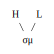

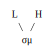

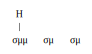

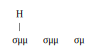

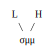

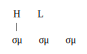

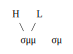

Found 8 constraints


[ , [(None, 3, 1)],
 HL , [(1, 1, 1), (2, 1, 1)],
 LH , [(1, 1, 1), (2, 1, 1)],
 H , [(1, 2, 1), (None, 1, 2), (None, 1, 3)],
 H , [(1, 2, 1), (None, 2, 2), (None, 1, 3)],
 LH , [(1, 2, 1), (2, 2, 1)],
 HL , [(1, 1, 1), (None, 1, 2), (2, None, None), (None, 1, 3)],
 HL , [(1, 2, 1), (None, 1, 2), (2, 2, 1)]]

In [3]:
from queue import Queue

def check_from_data(ar, positive_data, find = False):
    # Iterate over each autorep in the positive data
    for i in positive_data:
        # Check if the given autorep is a sub_structure of the current autorep in the loop
        if i.check_contain(ar):
            if find == True:
               print(i.word)
            # i.draw()
            # If it is, return True immediately
            return True
    # If the loop completes without finding any match, return False
    return False        


def check_from_grammar(ar, grammar):
    # Iterate over each autorep in the positive data
   for i in grammar:
      # Check if the given autorep contains the structure in the grammar
      if ar.check_contain(i):
         # If it is, then the grammar check fails
         return False
   # If the loop completes without finding any match, return True
   return True

from queue import Queue
from queue import Queue


def Get_Max_weight(D):
    sp = Autorep("","",[(None,3,1)]) 
    heavy = Autorep("","",[(None,2,1)]) 
    if check_from_data(sp,D):
        return 3
    elif check_from_data(heavy,D):
        return 2
    else:
        return 1
    
def bufia(D, t=2, s=2, m=5):
    D = autolist  # The list of autoreps (assumed to be defined already)
    t_threshold = t
    s_threshold = s

    Q = Queue()
    s0 = Autorep()  # Assuming Autorep is defined elsewhere
    V = []
    G = []
    Q.put(s0)
    max_syl_weight = Get_Max_weight(D)

    
    # Prepare the HTML file to save results
    with open("generated_results.html", "w") as outfile:
        # Start the HTML structure
        outfile.write("<html><head><title>Generated Results</title></head><body>\n")
        outfile.write("<h1>Generated Constraints</h1>\n")

        counter = 0  # Initialize the counter here
        while not Q.empty():
            s = Q.get()
            V.append(s)

            if check_from_data(s, D):  # Assuming check_from_data is defined elsewhere
                S = s.next_ar()  # Assuming next_ar() is defined elsewhere
                for i in S:
                    if (
                        i not in V and i not in G 
                        and check_from_grammar(i, G)  # Assuming check_from_grammar is defined elsewhere
                        and i.t_factor() <= t_threshold 
                        and i.s_factor() <= s_threshold 
                        and i.get_max('m') <= m
                    ):
                        Q.put(i)
            else:
                if s not in G and check_from_grammar(s, G):
                    counter += 1  # Increment the counter on each valid constraint
                    image_path = s.draw(f"cons{counter}",True)  # This will save and return the file path
                    s.draw()
                    G.append(s)

                    # Log everything to the HTML file
                    outfile.write(f"<h2>Constraint {counter}:</h2>\n")
                    outfile.write(f"<p>{s.info()}</p>\n")
                    outfile.write(f"<img src='{image_path}' alt='cons{counter}'>\n")
                    outfile.write("<hr>\n")

        # Close the HTML structure
        outfile.write("</body></html>\n")

    print(f'Found {len(G)} constraints')
    return G 


# Run the function
bufia(autolist, 2, 3)

